Rappels
* [GO ontology](https://www.ebi.ac.uk/QuickGO/)
* enrichissement
* Virtual Env // Jupyter
* Papier Christian

```bash
    git clone 
    sudo pip3 install scipy pandas PyQt5 ete3 owlready2 ipywidgets pyproteinsExt matplotlib 


```

DEGUB: Checking for DAG topology preservation, remaining srtructure seems w/out multiple parents per node

```python
def fn(node):
    #print(set(node.getMembers()) & set(saList))
    return set(node.getMembers()) & set(saList)

dTree = xpGoTree.drop(fn)
print(f"{xpGoTree.dimensions} -> {dTree.dimensions}")
for d in dTree.as_DAG_strat():
    if len(d["parentIds"]) > 1:
        print(d)
```

In [1]:
import sys

cDir="/Users/guillaumelaunay/work/communications/lectures/UCBL/M2_bioinfo/VDB/Python_D3_project"
dataDir=cDir + "/data" 

#dataDir="/ifb/data/public/teachdata/m2binf_ucbl/data"

sys.path.append(cDir + '/lib')

# sudo pip3 install scipy pandas
# Attention pip3 uninstall si erreur
# et reinstall en sudo

In [2]:
import pandas, uniprot, go
from stat_utils import computeORA_BKG

%load_ext autoreload
%autoreload 2

## Jeux de données
* Experimental dataset as XLS
* Go ontology as [owl](http://www.obofoundry.org/ontology/go.html)
* Uniprot entries as XML files

## Objectifs
1. Lire et traiter des données d'entrée avec [PANDAS](https://pandas.pydata.org/)

2. Représenter la distribution empirique des "fold-change" (**FC**)

3. Evaluer un seuil de **FDR** 5%, with normal approximation
    1. Proposer une function qui à un seuil de faux-positif retourne une valeur de **FDC**
    2. Proposer une fonction qui appelle la précedente et retourne, en plus, une représentation graphique

4. Analyse de l'enrichissement en pathway Gene Ontology
    1. Arbre des termes d'ontologie.
        * Visualisation de l'arbre complet
    2. Modélisation hypergéometrique des fréquence attendues des termes GO
        * Les protéines très abondantes présentent-elles des termes GO en quantité remarquable ?
        * Les protéines peu abondantes présentent-elles des termes GO en quantité remarquable ?
    3. Visualisation de l'arbre avec style des noeuds rendant compte des protéines qu'ils annotent
 
5. Volcano plot
    1. Scatter-Plot **FC** vs **LOG10 Adj.P-val**
    2. Colorer les protéines très/peu abondantes
    3. ipyWidget slider FDR permettant de changer les seuils "d'abondance" 
    
6. Volcano Plot présentant les pathways
    1. ipyWidget Slider
    2. Coloration des points pour les protéines annotées par ce pathway 

## Conclusion
* Compare wt/mutant conditions


## Ressources
https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html

https://matplotlib.org/gallery.html#




## Plan Experimental

Organisme modèle

Questions posées

Protocole biologique

PRotocler de Mesue

Nature des données à analyser

## Format des données expérimentales

Le terme *SA*, désigne le ratio de (**S**ur) **A**bondance pour une protéines entre deux experiences.
Les valeurs de **SA** sont stockées dans la colonne ```Log2 Corrected Abundance Ratio```. Un "ratio" négatif indique qu'une protéine est moins présente dans l'experience considéré par rapport à une experience de référence.

* La condition experimentale de référence est un milieu de croissance bactérienne
* La condition experimentale testée est un milieu riche en Tétracycline 



# Première exploration des données

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
* Retirer les lignes présentant des aberrations numériques

##### [Comment filtrer des lignes Pandas](https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/)

In [3]:
import pandas
df=pandas.read_csv(cDir + "/TCL_wt1.tsv", delimiter ="\t")
df.head()

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075816993,-3.721334942,0.000055,4.260067469
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810458,-3.429568818,0.000351,3.45462743
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614379,-3.284695189,0.000027,4.571899347
3,P0CE48,Elongation factor Tu 2 OS=Escherichia coli (st...,tufB,#VALEUR!,#VALEUR!,NaN,#VALEUR!
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108496732,-3.204276506,0.019963,1.699767669


In [4]:
dfClean = df[ (df['Log2 Corrected Abundance Ratio'] != '#VALEUR!') & (df['LOG10 Adj.P-val'] != '#VALEUR!')]
dfClean = dfClean.copy()
dfClean.loc[:,'Log2 Corrected Abundance Ratio'] = dfClean.loc[:,'Log2 Corrected Abundance Ratio'].astype(float)
dfClean.head()

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075816993,-3.721335,0.000055,4.260067469
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810458,-3.429569,0.000351,3.45462743
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614379,-3.284695,0.000027,4.571899347
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108496732,-3.204277,0.019963,1.699767669
5,P29744,Flagellar hook-associated protein 3 OS=Escheri...,flgL,0.124183007,-3.009460,0.036746,1.434786589


### Visualisation de la distribution empirique
Représenter la distribution des **SA** de l'experience.
* [matplotlib histogramme](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html)
* implémenter ce graphique dans une fonction 
```python 
    def empirical(data:pandas.Series)
```

##### [API des colonnes pandas](https://pandas.pydata.org/pandas-docs/version/0.24/reference/series.html)


In [133]:
import matplotlib
%matplotlib inline
# By default matplotlib is inline,
# graphic is shown without need fot plt.show

import matplotlib.pyplot as plt

def empirical(data):
    d = data['Log2 Corrected Abundance Ratio'].tolist()
    plt.hist(d, bins=50,density=False, color='#4682B4', alpha=0.6)
    plt.ylabel('Number of proteins')
    plt.xlabel('Log2 Corrected Abundance Ratio')

def empirical2(data, density=False):
    d = data['Log2 Corrected Abundance Ratio'].tolist()
    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    ax.hist(d, bins=50,density=density, color='#4682B4', alpha=0.6)
    ax.set_ylabel('Number of proteins')
    ax.set_xlabel('Log2 Corrected Abundance Ratio')
    return fig, ax


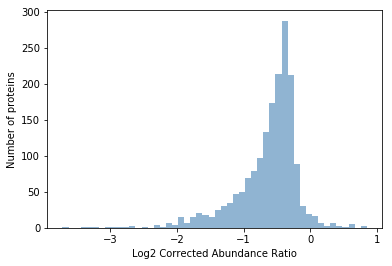

In [114]:
empirical(dfClean)

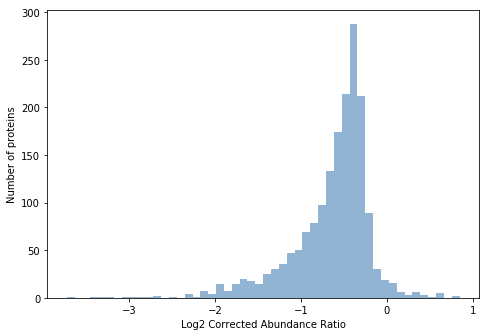

In [127]:
fig, ax = empirical2(dfClean)

### Distribution théorique attendue
Entre deux experiences, les quantités d'une protéine non affectée par le changement de conditions devraient-elles être strictement identiques ?

Proposer une distribution théorique des **SA** des protéines **non affectées** par le changement de conditions.
 * Calculer les paramètres de cette distribution à partir de l'échantillon
 * Représenter ces paramètres par des lignes verticales sur l'histogramme précedent

Implémenter une fonction qui prend un échantillon et **dessine** la distribution théorique et empirique. Elle utilisera la fonction ```empirical()```

```python 
    def empiricalAndTheoric(data:pandas.Series)
```



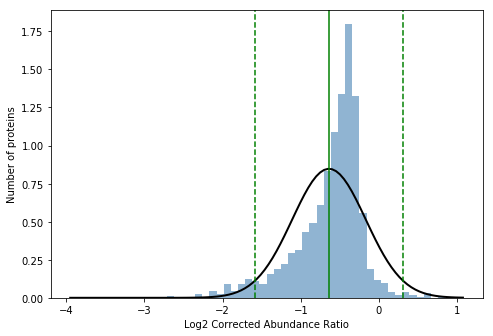

In [139]:
from scipy.stats import norm

def empiricalAndTheoric(data:pandas.Series):
    #print(data)
    d = data['Log2 Corrected Abundance Ratio'].tolist()
    # Fit a normal distribution to the data:
    mu, std = norm.fit(d)
    fig, ax = empirical2(data, density=True)
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.axvline(x=mu, color='g')
    plt.axvline(x=mu + 2 * std, color='g', linestyle='--')
    plt.axvline(x=mu - 2 * std, color='g', linestyle='--')
    
empiricalAndTheoric(dfClean)

### Seuil de significativité
Comment déterminer un seuil de *SA* au delà duquel seulement 5% des protéines non affectées seraient selectionnées ?

Pour une Méthode de reconnaissance des protéines sur abondantes que siginifie ce taux de 5% ?

Implémenter une fonction qui prend un échantillon un pourcentage en argument, appelle la précedente et retourne une valeur seuil.

```python 
    def FDR_threshold(data:pandas.Series, t=0.05) # Où t peut valoir 5%, 2.5% ou 1%
```

Creer la fonction suivante
```python
empiricalAndTheoricTreshold(data:pandas.Series, t=0.05)
```

Elle combinera les fonctions ```FDR_threshold``` et ```empiricalAndTheoric``` pour ajouter à son histogramme une ligne verticale rouge à l'emplacement du seuil.




In [153]:
def FDR_threshold(data, tau=0.05):
    tau = 1 - tau
    d = data['Log2 Corrected Abundance Ratio'].tolist()
    mu, std = norm.fit(d)
    
    return norm.ppf(tau, loc=mu, scale=std)

FDR_threshold(dfClean)

0.1355573136539573

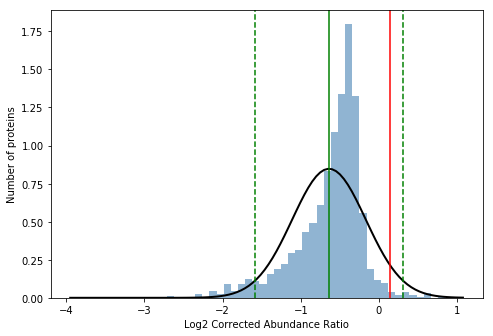

In [155]:
def empiricalAndTheoricTreshold(data:pandas.Series, tau=0.05):
    v = FDR_threshold(data, tau=tau)
    empiricalAndTheoric(data)
    plt.axvline(x=v, color='r')

empiricalAndTheoricTreshold(dfClean, tau = 0.05)

### Visualisation des seuils et de la distribution empirique
Implémenter une fonction qui prend un échantillon et dessine la distribution théorique, empirique et colore [l'aire sous la courbe](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.fill_between.html) théorique au delà du seuil demandé.
Vous pourrez ajouter les légendes correspondant à $\mu, 2\sigma, \tau$ 

```python 
    def empiricalAndTheoricThresholdArea(SA_list, parameters*)
```


### Pour aller plus loin
https://en.wikipedia.org/wiki/Cauchy_distribution

***

# Definitions de pathway fonctionels


Jeux de données de protéines

Experimentales

Référence:



### Evaluation théorique de l'abondance

* $Q+$ : Proteines Sur-représentées
* $\overline{Q+}$ : Proteines non Sur-représentées

* $PW^{a}$ : Nombre de protéines membres du Pathway$a$
* $\overline{PW^{a}}$ : Nombre de protéines non-membres du Pathway$a$



 Proteines | $Q+$  | $\overline{Q+}$ | Total lignes
 :--- | --- |--- |---|
membres de $PW^{a}$  | $PW^{a}_{Q+}$ | $PW^{a}_{\overline{Q+}}$ | $nPW^{a}$
non-membres de $PW_{a}$ | $\overline{PW^{a}}_{Q+}$ | $\overline{PW^{a}}_{\overline{Q+}}$ | $n\overline{PW^{a}}$
  **Total colonnes** | n$Q+$ | n$\overline{Q+}$ | **nTOT**
 
 
**Question**:"Le nombre de protéines sur-représentées dans le Pathway$a$ est-il grand comparé à ce qui serait attendu au hasard?"


<!--## Deprecated 
 **Question**:"Les protéines sur-représentées sont-elles plus fréquentes dans le Pathway$a$ que dans les protéines non-membre du Pathway$X$?"
 
L'hypothèse nulle est "Les protéines membres du pathway et non-membres du pathway ont des quantifications similaires".
 -->
        

### Modélisation du hasard par une loi hypergéométrique

Pour un pathway donné ($PWa$), chaque protéine sur-abondante peut être vue comme un tirage dans le pool de protéines de l'expérience. La population de ce pool est consituée de deux groupes:
 * Le groupe des protéines appartenant à $PWa$
 * Les autres

La probabilité d'observer $k$ protéines de $PWa$ parmi les $n$ sur-abondantes se modélise alors naturellement par la loi de probabilité hypergéométrique.

Rappellez-vous,

Si X est la variable aléatoire du nombre de succès parmi n observations, sans remise.
Alors la probabilité d'oberver exactement $k$ succès, suit une loi hypergéométrique de paramètres $N, n$ et $k$

$P(X=k) = \frac{ {K\choose k} {N-K\choose n-k} } { {N\choose K} }$

où


* $K$ est le nombre de succès dans la population totale
* $n$ est le nombre d'observations
* $N$ est la taille de la population totale
* $k$ est le nombre de succès parmi les observations

Si **pour chaque $Pathway^{a}$**, $X$ est la variable aléatoire du **nombre de protéines sur-représentée** dans l'experience.


Cocher les relations correspondantes


  x  | $nTOT$ | $PW^{a}_{Q+}$ | $nPW^{a}$ | $nQ+$
 --- | ---   | ---     | ---  | --- |
 $K$ |       |         |      | 
 $n$ |       |         |      | 
 $N$ |       |         |      | 
 $k$ |       |         |      | 
 
 
 
 
Rappel: $nPW^{a}_{Q+}$ est le nombre de protéines appartenant au $Pathway^{a}$ parmi les protéines surexprimées

Que représentent alors les deux expressions suivantes:

$ P(X=nPW^{a}_{Q+}) \frac{ {nPW^{a}\choose X} {n\overline{PW^{a}}\choose nQ^{+} - X} } { {nTOT\choose nPW^{a}} }$


$P(X >= PW^{a}_{Q+})  = \sum_{x_{i}=PW^{a}_{Q+}}^{x_{i} \le nQ+}\frac{ {nPW^{a}\choose x_{i}} {n\overline{PW^{a}}\choose nQ^{+} - x_{i}} } { {nTOT\choose nPW^{a}} }$


In [5]:
uniprotCollection = uniprot.UniprotCollection(dataDir +"/dataset")
K12 = uniprot.UniprotCollection(dataDir + "/K12_proteome/")

In [34]:
go.setOntology(dataDir + "/go.owl")

Loaded


In [36]:
xpProtList = dfClean['Accession'].tolist()

print("Extracting biological process ontology")
xpGoTree_BP = go.AnnotationTree("biological process", collapse=True)
xpGoTree_BP.extract(xpProtList, uniprotCollection)

fullEcoliGoTree_BP = go.AnnotationTree("biological process", collapse=True)
fullEcoliGoTree_BP.extract(K12.list, K12)
# check that :: 2728 leaves, 6650 nodes, 3128 proteins
print("Extracting molecular function ontology")
xpGoTree_MF = go.AnnotationTree("molecular function", collapse=True)
xpGoTree_MF.extract(xpProtList, uniprotCollection)

fullEcoliGoTree_MF = go.AnnotationTree("molecular function", collapse=True)
fullEcoliGoTree_MF.extract(K12.list, K12)

print("Extracting cellular component ontology")
xpGoTree_CC = go.AnnotationTree("cellular component", collapse=True)
xpGoTree_CC.extract(xpProtList, uniprotCollection)

fullEcoliGoTree_CC = go.AnnotationTree("cellular component", collapse=True)
fullEcoliGoTree_CC.extract(K12.list, K12)

Extracting biological process ontology
Applying true path collapsing
2194 leaves, 3482 nodes, 1474 proteins
Applying true path collapsing
2728 leaves, 6650 nodes, 3128 proteins
Extracting molecular function ontology
Applying true path collapsing
1694 leaves, 4328 nodes, 1517 proteins
Applying true path collapsing
2264 leaves, 7807 nodes, 3118 proteins
Extracting cellular component ontology
Applying true path collapsing
209 leaves, 2324 nodes, 1426 proteins
Applying true path collapsing
239 leaves, 4698 nodes, 2805 proteins


## Manipulation de termes GO à l'aide de *go.py*

Règle du vrai chemin: *Si une protéine est porteuse d'un terme GO, alors est elle aussi porteuse de tous les parents de ce terme.*

### AnnotationTree est l'arbre des annotations GO portées par une collection de proteines 

#### Un arbre ne rend compte que d'un seul namespace GO
On définit le namespaced des termes GO à extraire par un de ces trois termes : 
* "biological process", "molecular function", "cellular component"
 
```python
aTree = go.AnnotationTree("biological process", collapse=True)
```
On ne garde dans cet arbre que les termes portés par les protéines données en dernier argument
```python
aTree.read_DAG(['P75936', 'P76231', 'P0A8S9'], uniprotCollection)
```

### API de l'arbre d'annotations


#### Taille de l'abre
```python
aTree.dimensions
```

#### Extraire un sous arbre
```python
bTree = aTree.newRoot("transmembrane transport")
```

#### Enumerer les protéines porteuses de termes GO

##### Dans tout l'arbre
```python
proteinList = aTree.getMembers()
```
##### A partir d'un noeud
```python
proteinList = aTree.getMembersByName("transmembrane transport")
proteinList = aTree.getMembersByID("GO:0055085")
```

#### Acceder directement à un noeud
```python
goTerm = aTree.getByName("transmembrane transport")
goTerm = aTree.getByID("GO:0055085")
```

#### Elager un arbre
Retirer tous les noeuds n'ayant aucun des éléments suivants parmi leurs protéines annotées

```python
def predicat(goTerm):
    return set(goTerm.getMembers()) & set(['P75936', 'P76231', 'P0A8S9'])

bTree = aTree.drop(predicat)
```

###### Créer la fonction qui retournera la probabilité, sous un [modèle hypergeométrique](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.hypergeom.html), d'obtenir $k$ succès ou plus,

```python
def righEnd_pValue(N, n, K, k) => p
```
Aux arguments:
* $N$, le nombre total d'objet
* $n$, le nombre de tirages
* $K$, le nombre total d'objet de *typeI*
* $k$, le nombre de tirage d'objet de *typeI* (ie: nombre de succès parmi les tirages)

##### Dessiner les courbes de la densité de probabilité et de la densité cumulée de la loi

L'enrichissement en terme GO parmi les protéines surabondantes sera estimé par cette fonction, avec
* $N$, le nombre total de protéines annotées dans le protéome
* $n$, le nombre de protéines surabondantes
* $K$, le nombre de protéines annotées par ce terme GO dans le protéome
* $k$, le nombre de protéines annotées par ce terme GO dans les protéines surabondantes

###### Evaluer la pValue d'enrichissment en terme GO d'une liste de protéine donnée

Avant d'appeler `righEnd_pValue`, on devra donc

1. Lister les protéines surabondantes
2. Lister toutes les protéines sous le terme GO de votre choix 
    1. dans l'experience
    2. dans le protéome
3. Calculer l'intersection entre *1* et *2.A*

###### *Hint:*
Vous vous aiderez 
- de l'API de `go.annotationTree` 
- des commandes [`set` de python](https://docs.python.org/3/library/stdtypes.html#set)
- du [filtrage de colonne Pandas](https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/) pour évaluer la liste de protéines surabondantes
- de la [fonction subplot de matplotlib](https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python), pour dessiner les deux courbes cote-à-cote

Le pathway transmembrane transport a une pValue de 0.38144 (5 membres)


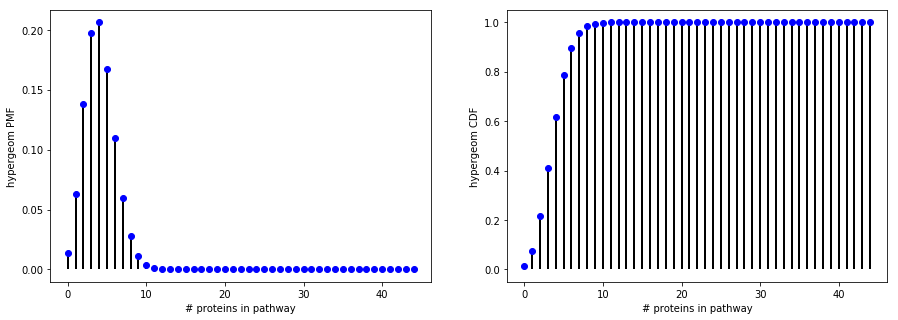

In [102]:
from scipy.stats import hypergeom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()

def righEnd_pValue(N, n, K, k):
    
    rv = hypergeom(N, K, n)
    x = np.arange(0, n+1)
    pmf_pathway_members = rv.pmf(x)
    cmf_pathway_members = rv.cdf(x)
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(121)
    ax.plot(x, pmf_pathway_members, 'bo')
    ax.vlines(x, 0, pmf_pathway_members, lw=2)
    ax.set_xlabel('# proteins in pathway')
    ax.set_ylabel('hypergeom PMF')
    
    ax = fig.add_subplot(122)
    ax.plot(x, cmf_pathway_members, 'bo')
    ax.vlines(x, 0, cmf_pathway_members, lw=2)
    ax.set_xlabel('# proteins in pathway')
    ax.set_ylabel('hypergeom CDF')
    
    
    
    p_x = hypergeom(N, K, n).cdf([k - 1])
    return 1.00 - p_x[0]

pathwayName="transmembrane transport"
x = set(saList)
o = set(fullEcoliGoTree_BP.getMembers())
a = set(fullEcoliGoTree_BP.getMembersByName(pathwayName))
b = set(xpGoTree_BP.getMembersByName(pathwayName))
pvalue=righEnd_pValue(len(o), len(saList), len(a), len(b & x))

print(f"Le pathway {pathwayName} a une pValue de {pvalue:.5f} ({len(b & x)} membres)")

## Analyse de la surreprésentation

Le package *stat_utils.py* permet d'appliquer cette analyse récursivement, en profondeur, à partir d'un terme GO général.

#### Estimation récursive des enrichissements

* Choix du terme GO général
```python
pathWayRoot = xpGoTree.getByName("transmembrane transport")
```

* Définition du terme GO regroupant tout le protéome
```python
pathWayBKG = fullEcoliGoTree.getByName("biological process")
```

* Calcul de l'enrichissement en termes GO successifs parmi les protéines surabondantes (ici, *saList*)
```python
oraFisher, oraCDF = computeORA_BKG(pathWayRoot, saList, pathWayBKG)
```
* Des arbres peuvent également être passés.
```python
tm_transport_GoTree = xpGoTree.newRoot("transmembrane transport")
oraFisher, oraCDF = computeORA_BKG(tm_transport_GoTree, saList, fullEcoliGoTree)
```

#### Affichage des enrichissements
La fonction ci-dessous va vous permettre d'afficher les pathway par ordre croissant de p-value
```python
def printRankings(saList,_oraFisher, _oraCDF):
    fisherRanking = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(saList) ), len(saList) ) for d in sorted(oraFisher, key=lambda x:x[0]) ]
    cdfRanking = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(saList) ), len(saList) ) for d in sorted(oraCDF, key=lambda x:x[0]) ]
    print(f"FISHER test Rankings:\n{fisherRanking}")
    print('\n---\n')
    print(f"CDF Rankings:\n{cdfRanking}")
```

##### Intégration des résultats à la visualisation du notebook 

En vous inspirant de la fonction ci-dessus, proposer une classe `Rankings` implémentant une méthode [`_repr_html_`](https://ipython.readthedocs.io/en/stable/config/integrating.html) qui permette un affichage plus lisible des résultats, comme par exemple:

![caption](figs/_repr_html_.png)

#### Appliquer cette analyse à terme GO de votre choix (et tous ses fils)
 - Il serait souhaitable d'encapsuler les différentes étapes dans une fonction de ce type
```python
    def computePathway(goTermString, xpTreeTerm, bkgTreeTerm, uniprotIdList) -> oraFisher, oraCDF
```
#### Appliquer cette analyse à tous les termes GO des arbres "biological process", "molecular function", "cellular component"

***


##### STEP by STEP solution

In [103]:
pathWaySetRoot    = xpGoTree_BP.getByName("transmembrane transport")
pathWaySetRootBKG = fullEcoliGoTree_BP.getByName("biological process")

In [104]:
class Rankings():
    def __init__(self, oraResults, proteinList, title="Pathway ORA"):
        self.title = title
        self.ranks = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(proteinList) ), len(proteinList) ) for d in sorted(oraResults, key=lambda x:x[0]) ]
    def _repr_html_(self):
        t_head = f"<h3>{self.title}</h3><table><thead><th>p-value</th><th>Pathway name</th><th>n</th></thead><tbody>"
        t_foot = '</tbody></table>'
        t_body = '</tr><tr>'.join([ '<td>' + '</td><td>'.join([ str(v) for v in pathwayScore ][:-1]) + '</td>' for pathwayScore in self.ranks ])
        t_body = '<tr>' + t_body + '</tr>'
        return t_head + t_body + t_foot

In [105]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
oraFisher, oraCDF = computeORA_BKG(pathWaySetRoot, saList, pathWaySetRootBKG)
Rankings(oraFisher,saList, title="biological process")

Evaluated 9 / 97 Pathways, based on 44 proteins


0.026319852884717568,ion transmembrane transport,5
0.04106508166120274,L-glutamate transmembrane transport,1
0.12358508050517482,drug transmembrane transport,2
0.22290599826510718,L-alpha-amino acid transmembrane transport,1
0.3619566723145079,amino acid transmembrane transport,1
0.3826117782409264,transmembrane transport,5
0.46911833019397486,carboxylic acid transmembrane transport,1
0.46911833019397486,organic acid transmembrane transport,1
0.571013396124047,anion transmembrane transport,1


#### Single function solution

In [106]:
def computePathway(goTermString, xpTreeTerm, bkgTreeTerm, bkgTermString, uniprotIdList) :
    pathWaySetRoot    = xpTreeTerm.getByName(goTermString)
    pathWaySetRootBKG = bkgTreeTerm.getByName(bkgTermString)
    oraFisher, oraCDF = computeORA_BKG(pathWaySetRoot, uniprotIdList, pathWaySetRootBKG)
    return oraFisher, oraCDF, Rankings(oraFisher,uniprotIdList, title=goTermString)

In [107]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
bp_analysis = computePathway("biological process", xpGoTree_BP, fullEcoliGoTree_BP, "biological process", saList)
bp_analysis[2]

Evaluated 297 / 2193 Pathways, based on 44 proteins


3.0740143676824805e-06,siderophore transport,5
1.4333376891745052e-05,iron coordination entity transport,5
2.9305999920744405e-05,protein insertion into membrane,4
3.1801614970675325e-05,membrane organization,5
5.221318723734416e-05,Gram-negative-bacterium-type cell outer membrane assembly,4
5.221318723734416e-05,membrane assembly,4
6.758963970377286e-05,establishment of protein localization to membrane,4
0.0001285368129330478,iron ion transport,5
0.00019634523788932085,ion transport,13
0.00023663274449265561,protein localization to membrane,4
0.0002536535809632806,macromolecule localization,8


In [82]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
mf_analysis = computePathway("molecular function", xpGoTree_MF, fullEcoliGoTree_MF, "molecular function", saList)
mf_analysis[2]

Evaluated 135 / 1693 Pathways, based on 44 proteins


4.079020213798363e-08,porin activity,8
5.4812535572080815e-08,channel activity,9
6.842147218688606e-05,protein domain specific binding,4
0.00013509993026375214,signaling receptor activity,4
0.0005635570539397125,protein N-terminus binding,2
0.0011171295071511346,5S rRNA binding,2
0.0011171295071511346,"protein binding, bridging",2
0.0011171295071511346,colicin transmembrane transporter activity,2
0.0011171295071511346,bacteriocin transmembrane transporter activity,2
0.0012444576470391796,ion channel activity,3
0.0018912053184272182,molecular transducer activity,4


In [91]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
mf_analysis = computePathway("cellular component", xpGoTree_CC, fullEcoliGoTree_CC, "cellular component", saList)
mf_analysis[2]

Evaluated 55 / 208 Pathways, based on 44 proteins


1.0215714911346547e-23,external encapsulating structure part,26
1.0215714911346547e-23,cell outer membrane,26
7.850474882875648e-23,outer membrane,26
9.371662207134898e-23,external encapsulating structure,26
7.407416447732138e-19,cell envelope,29
8.156120114973369e-19,envelope,29
8.303624740016611e-11,intrinsic component of cell outer membrane,9
8.250388960599696e-07,integral component of cell outer membrane,5
1.0578539711794813e-06,pore complex,6
3.3340106553038095e-06,Bam protein complex,4
2.214563121907388e-05,membrane protein complex,11


## Visualisation des arbres
Nous allons maintenant représenter la hiérarchie des termes GO portés par les protéines surreprésentées.
Dans un premier temps, il vous est conseillé de vous placer à un niveau suffisamment bas dans l'arbre pour constuire la visualisation avec peu de feuilles.

##### Elagage de l'arboresence GO
Nous souhaitons, éliminer les branches de l'arbre ne comportant aucune protéine surreprésentées.
On peut facilement obtenir toutes les protéines sous un terme GO donné, via l'API de l'arbre ou du terme GO.
```python
# Recupere depuis l'arbre toutes les occurences de protéines sous le noeud "intracellular part"
proteinIdList = aTree.getMembersByNames("intracellular part")
# Recupere le noeud "intracellular part" depuis l'arbre, puis toutes les occurences de protéines sous celui-ci
GOterm = aTree.getByNames("intracellular part")
_proteinIdList = GOTerm.getMembers()
set(_proteinIdList) == set(proteinIdList) # -> True
```

L'API arbre fournit la méthode **drop**, qui prend en argument une fonction prédicat qui sera appliquée récursivement à chaque terme de l'arbre. 
* Le prédicat recoit un unique argument, le terme à évaluer.
* Le prédicat doit retourner un booléen. 
* Si le prédicat retourne faux, le noeud évalué (ainsi que son sous-arbre) sera supprimé ("droped")

### ete3

La librairie [ete3](http://etetoolkit.org/) est une solution rapide pour déssiner des arbres en Python. 
Son intégration à [Jupyter](http://etetoolkit.org/ipython_notebook/) va vous permettre de dessiner la hiérarchie de termes GO portées par les protéines surreprésentées. Libre à vous d'essayer les différents ["layout"](http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#circular-tree-in-180-degrees)

### amélioration

Vous observerez que les arbres de termes GO des études experimentales ont été modifiés lors de l'analyse d'enrichissement. Chacun de leurs noeuds sont desormais porteurs:
* d'une p-value d'enrichissement : `aTree.getByName("pore complex").Fisher`
* d'une liste de protéines effectivement annotées : `aTree.getByName("pore complex").eTag`

Les proteines annotées par ce terme ou ses descendants sont toujours accessibles: `set( aTree.getMembersByName("pore complex") )`

Vous pouvez rendre compte de ses valeurs en modifiant couleurs et tailles des noeuds correspondant dans la représentation graphique.

***

In [94]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()

def fn(node):
    return set(node.getMembers()) & set(saList)

dTree = xpGoTree_CC.drop(fn)
print(f"{xpGoTree_CC.dimensions} -> {dTree.dimensions}")

(209, 2324, 1426) -> (53, 1999, 1388)


In [95]:
from ete3 import Tree, TreeStyle, NodeStyle
def drawRadial(viewTree):
    t = Tree(viewTree.as_newick(), format=8, quoted_node_names=True)
    #t.populate(30)
    ts = TreeStyle()
    ts.show_leaf_name = True
    ts.mode = "c"
    ts.arc_start = -180 # 0 degrees = 3 o'clock
    ts.arc_span = 270

    for n in t.traverse():
        if n.name == "":
            continue
        node = viewTree.getByName(n.name)
        nstyle = NodeStyle()

        if not node:
            print("->", n.name) 
        elif node.name == 'root':
            nstyle["fgcolor"] = "black"
        else :
            nstyle["fgcolor"] = "darkred" if len(node.eTag) > 0 else "steelblue"

        n.set_style(nstyle)
    return t.render(file_name="%%inline", w=1200, tree_style=ts)

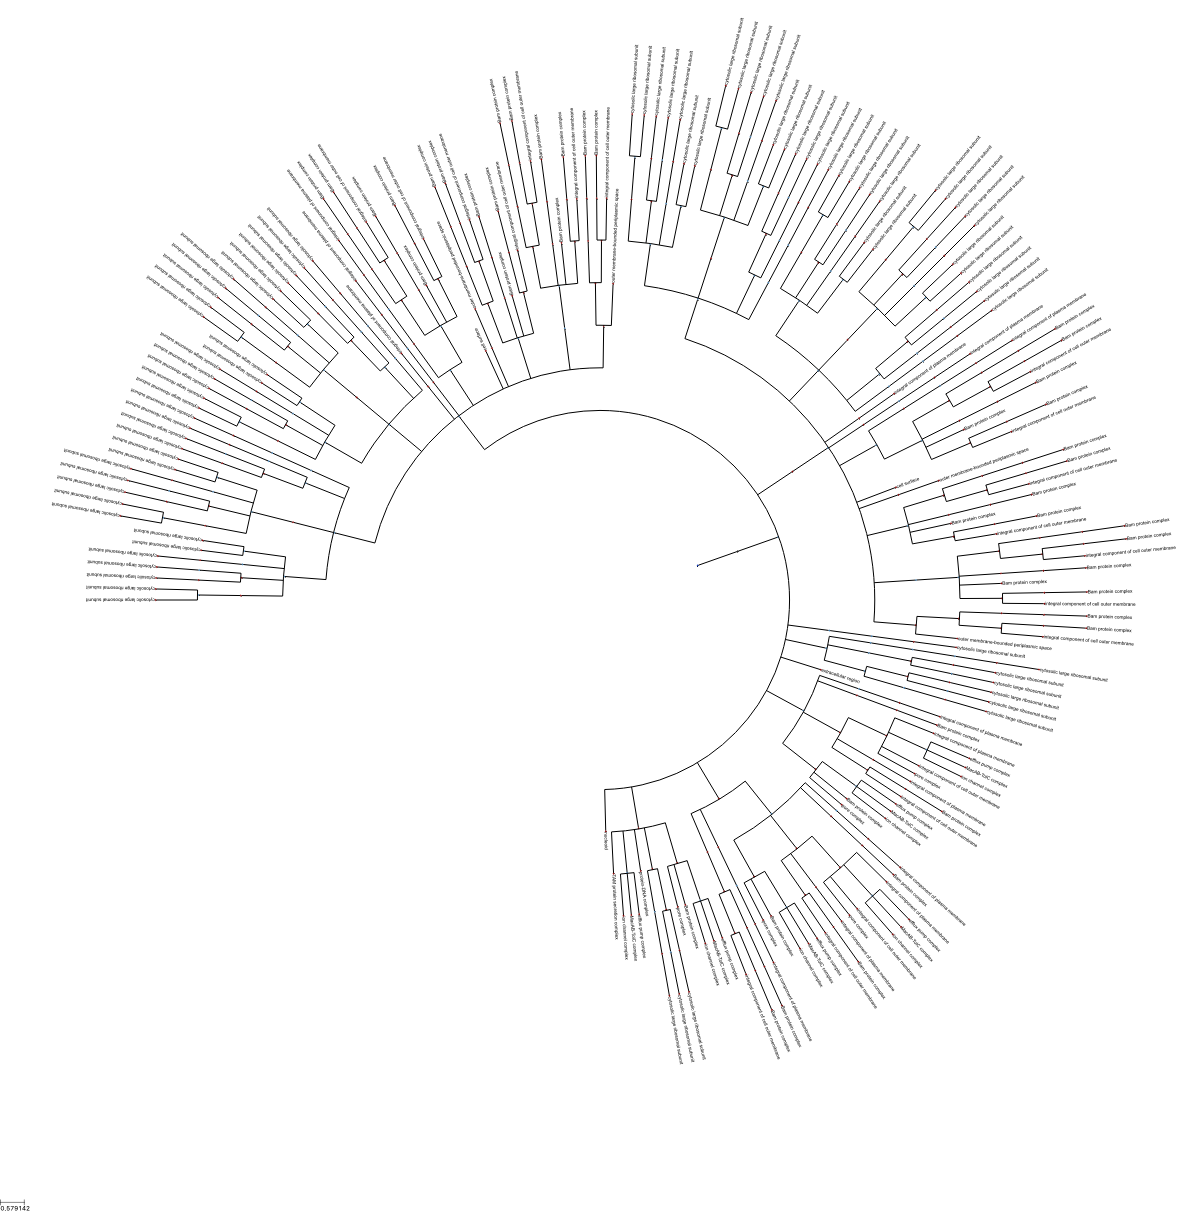

In [96]:
drawRadial(dTree)

In [100]:
import matplotlib
l=[ n.leafCount   for n in viewTree.traverse() ]
c_cmap = plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm([ wMin, np.percentile(l,25), np.percentile(l,50), np.percentile(l,75), wMax ], c_cmap.N)


In [392]:
c_cmap(norm(10))

(0.8333333333333333, 0.8660254037844388, 0.5000000000000001, 1.0)

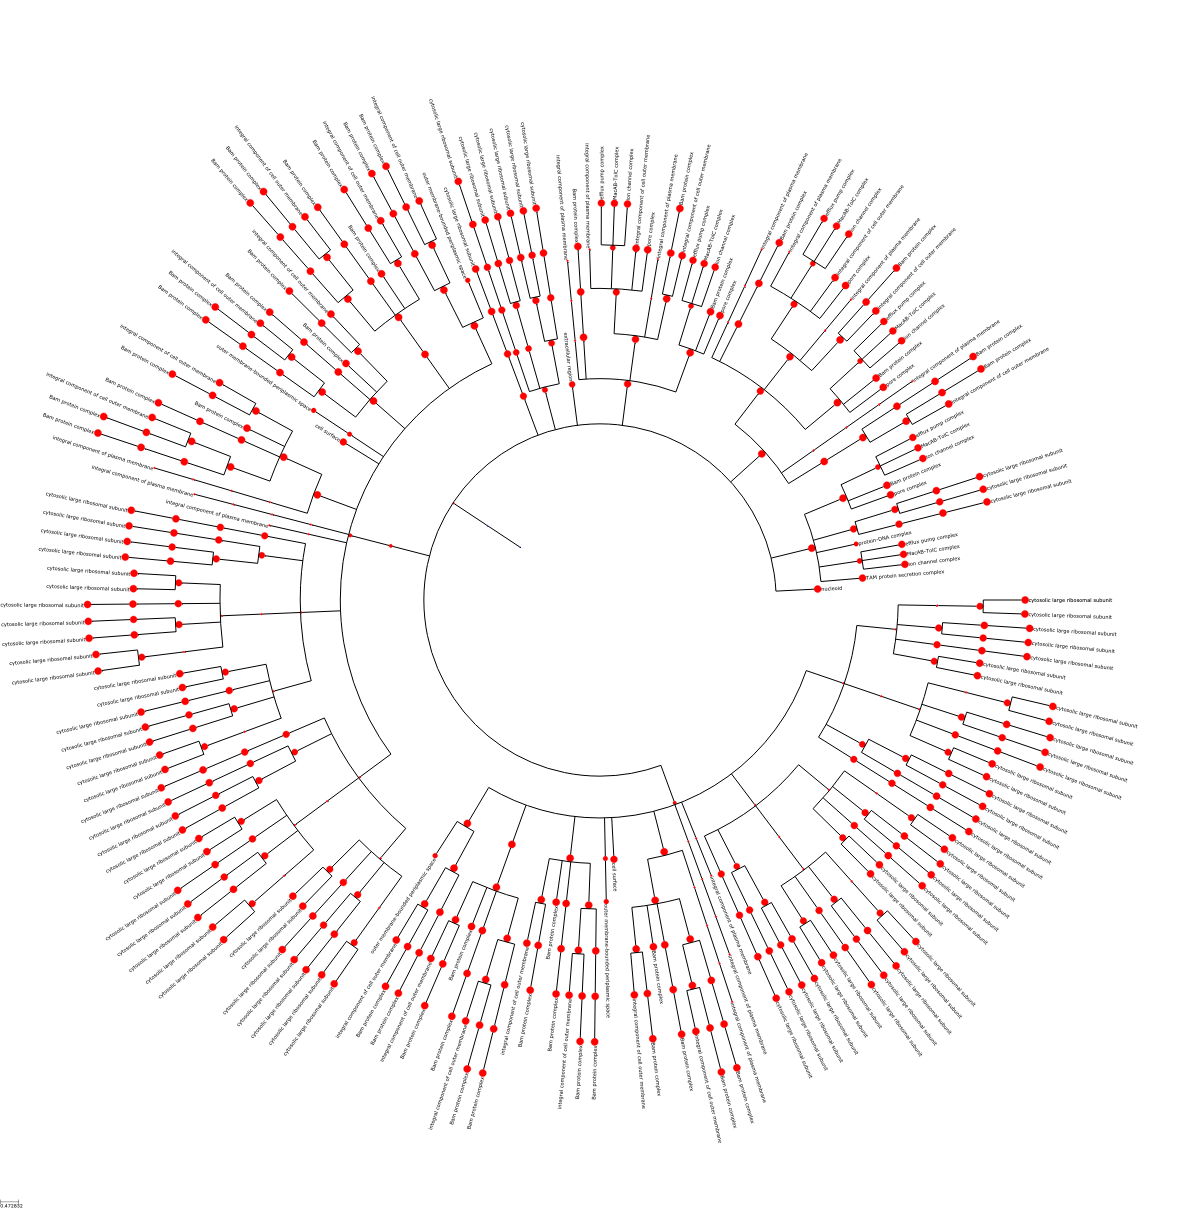

In [101]:
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace

import matplotlib.pyplot as plt
import matplotlib.colors as co

viewTree = dTree

wMin = min([ n.leafCount   for n in viewTree.traverse() ])
wMax = max([ n.leafCount   for n in viewTree.traverse() ])

[ n.leafCount   for n in viewTree.traverse() ]

def categoricalColorScale(value):
    v = c_cmap(norm(value))
    _v = co.ColorConverter.to_rgb(v)
    s = '%02x%02x%02x' % (int(_v[0]*255), int(_v[1]*255), int(_v[2]*255))
    #print(value, s)
    #print(_v)
    return f"#{s}"

def colorScale(value):
    #print (">>", value, wMin, wMax, "<<")
    norm = co.Normalize(vmin=wMin, vmax=wMax)
    cmap = plt.cm.winter
    v = cmap( norm(value) )
    #print(v)
    _v = co.ColorConverter.to_rgb(v)
    
    s = '%02x%02x%02x' % (int(_v[0]*255), int(_v[1]*255), int(_v[2]*255))
    #print(value, s)
    #print(_v)
    return f"#{s}"

def radiusScale(t):
    maxRadius, minRadius = (20, 5)
    return t *(minRadius - maxRadius) + maxRadius

def layout(node):
    if node.is_leaf():
        # Add node name to laef nodes
        N = AttrFace("name", fsize=14, fgcolor="black")
        faces.add_face_to_node(N, node, 0)
    return 
    
    
    if "weight" in node.features:
        # Creates a sphere face whose size is proportional to node's
        # feature "weight"
     #   col = colorScale(node.fisher)
        col = colorScale(node.weight)
        w = (1 - node.fisher) * 10
  #      print (col)
        #  C = CircleFace(radius=node.weight, color=QColor(*col), style="sphere")
#        C = CircleFace(radius=w, color=QColor(*col), style="sphere")
        C = CircleFace(radius=w, color=col, style="sphere")
        
        # Let's make the sphere transparent
        C.opacity = 0.3
        # And place as a float face over the tree
        #faces.add_face_to_node(C, node, 0, position="float")
t = Tree(viewTree.as_newick(), format=8, quoted_node_names=False)

for n in t.traverse():
    if n.name == "":
        continue
        
    node = viewTree.getByName(n.name)
   
    if not node:
        raise KeyError("Oups")
    if node.name == 'root':
        continue
    
    #print (node)
    
    w = node.leafCount
    #print ("-->", w)
    f = 1.0
    try:
        f = getattr(node, 'Fisher')
    except AttributeError:
        pass
    
    nstyle = NodeStyle()
    
    nstyle["fgcolor"] = categoricalColorScale(w)
    #print(node)
    nstyle["size"] = radiusScale(node.Fisher)

    n.set_style(nstyle)
    
    n.add_features(weight=w, fisher = f)

# Create an empty TreeStyle
ts = TreeStyle()

# Set our custom layout function
ts.layout_fn = layout

# Draw a tree
ts.mode = "c"

# We will add node names manually
ts.show_leaf_name = False
# Show branch data
ts.show_branch_length = False
ts.show_branch_support = False

t.render(file_name="%%inline", w=1200, tree_style=ts)


#### Visualisation des abondances et Pathway pour chaque protéine
Nous allons représenter la relation entre l'abondance des protéines (**Log2 Corrected Abundance Ratio**)  et la précision de la mesure (**LOG10 Adj.P-val**). Ceci se fera à l'aide de la commande matplotlibb [scatter](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html).
###### Volcano Plot global
* Creer la fonction drawScatter(abundanceList, precisionList) qui produira le graphique.
* Creer la fonction drawScatterPathway(goTermsList) 
    * Unique argument qui est une liste n goTerm aux p-value les plus faibles.
    * Dessine les protéines annotées par ces termes GO
    * Colorie de la même couleur, les protéines du même pathway
    * Si une protéine appartient à différents pathway, la priorité ira à celui de p-value la plus faible.

Au maximum 20 pathways pourront être représentés simultanément, vous utiliserez les [cartes de couleurs catégorielles](https://matplotlib.org/examples/color/colormaps_reference.html)

######  Volcano Plot interactif

Il serait plus intéressant de colorier les protéines d'un pathway donné à la volée, en mettant à jour le scatter plot à chaque fois. Jupyter fournit une libraire de composant interactif appelés [widgets](https://ipywidgets.readthedocs.io/en/stable/user_guide.html). 

* Construisez un widget `Dropdown` listant les pathway.


<IPython.core.display.Javascript object>


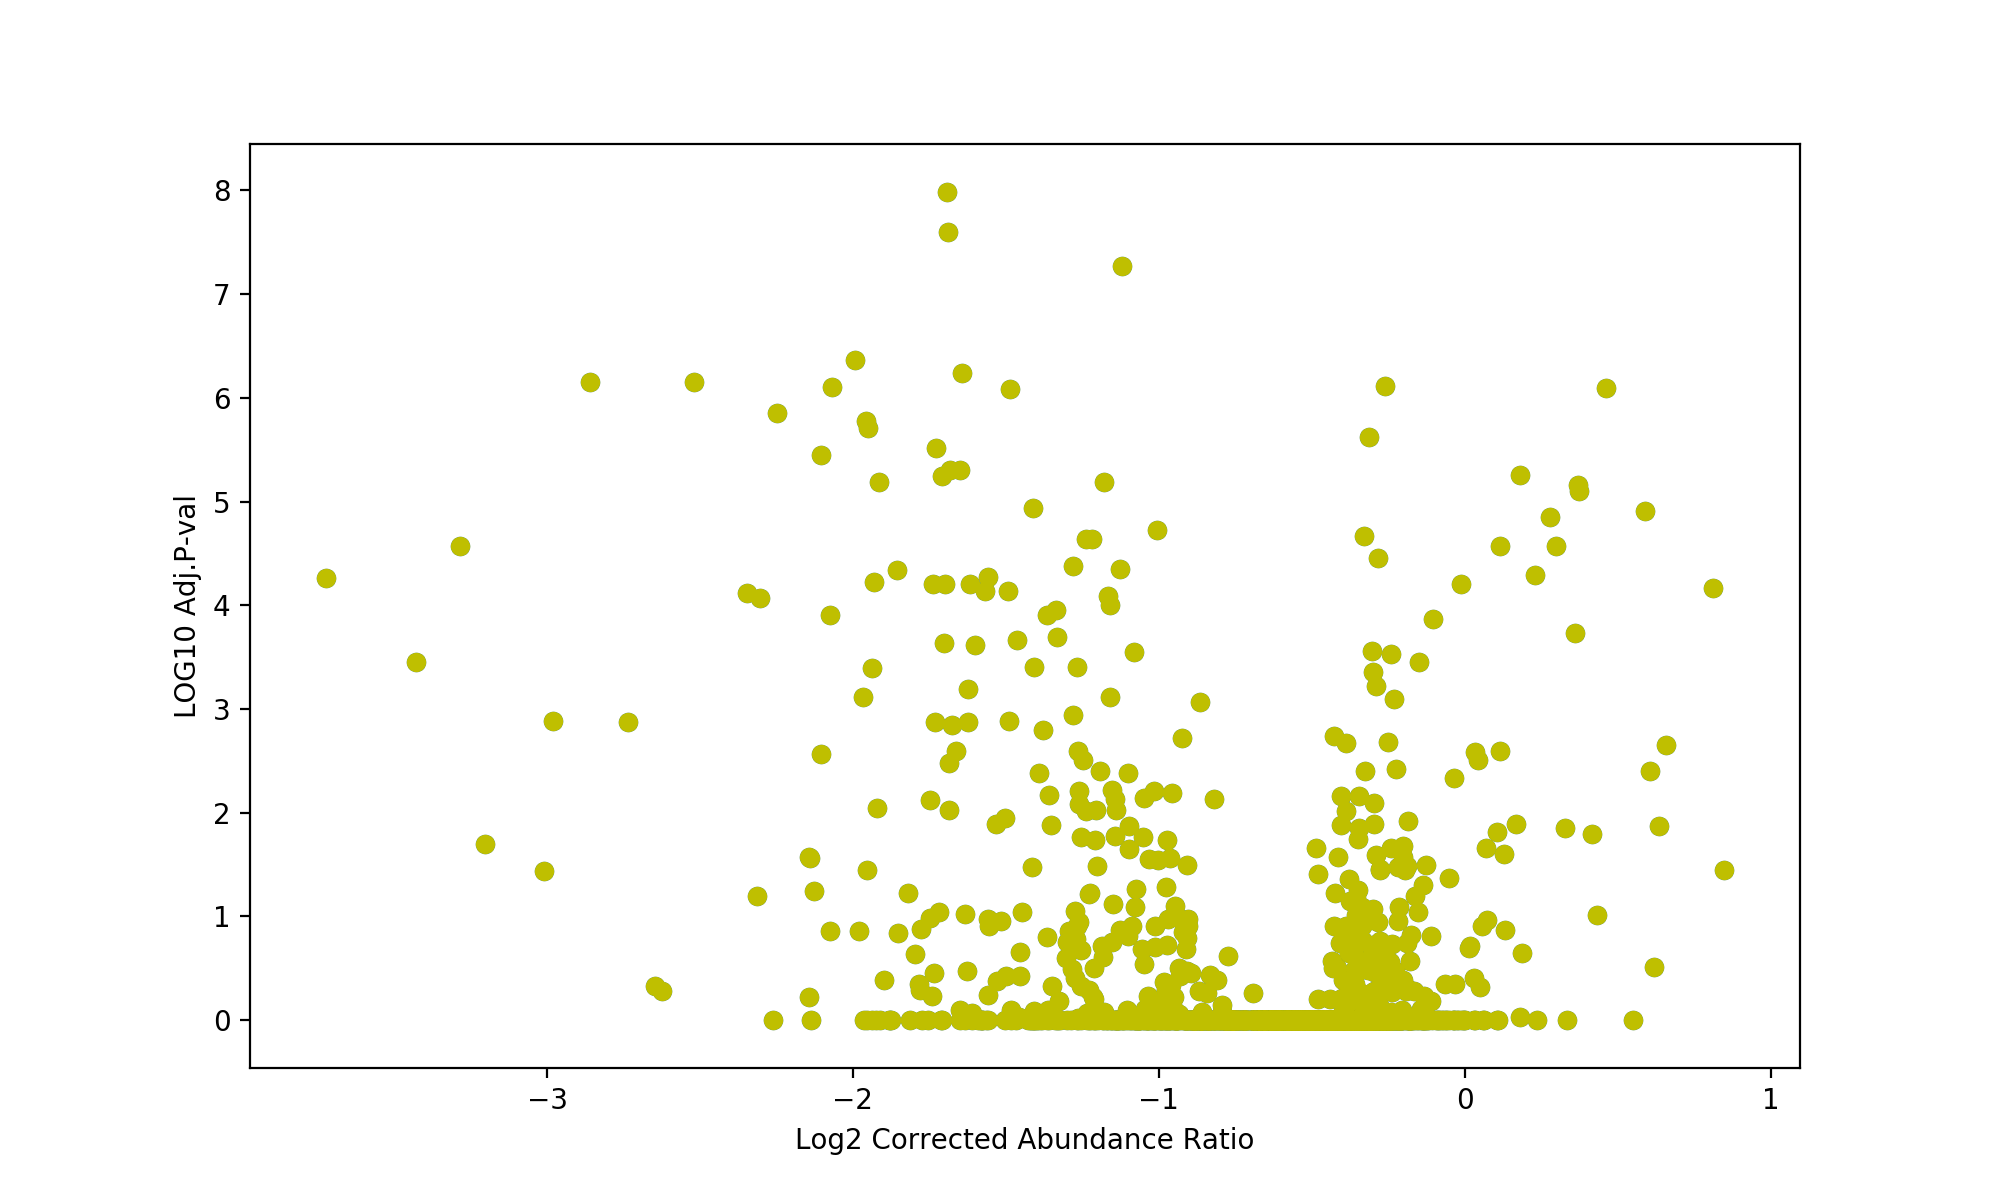

In [7]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
x = [ float(i) for i in dfClean['Log2 Corrected Abundance Ratio'].tolist() ]
y = [ float(i) for i in dfClean['LOG10 Adj.P-val'].tolist() ]
labels = dfClean['Accession'].tolist()
def drawScatter(x, y):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.yticks(np.arange(min(y), max(y)+1, 1.0))
    plt.scatter(x, y)
    scat = ax.scatter(x, y, color='y', picker=5)
    plt.ylabel('LOG10 Adj.P-val')
    plt.xlabel('Log2 Corrected Abundance Ratio')
    return scat, fig, ax
    
scat, fig, ax = drawScatter(x,y)

Dropdown(description='Clicks select:', options=('PathwayX', 'PathwayY', 'Pathway Z'), value='PathwayX')

FloatRangeSlider(value=(5.0, 7.5), continuous_update=False, description='Test:', max=10.0, readout_format='.1f…

<IPython.core.display.Javascript object>


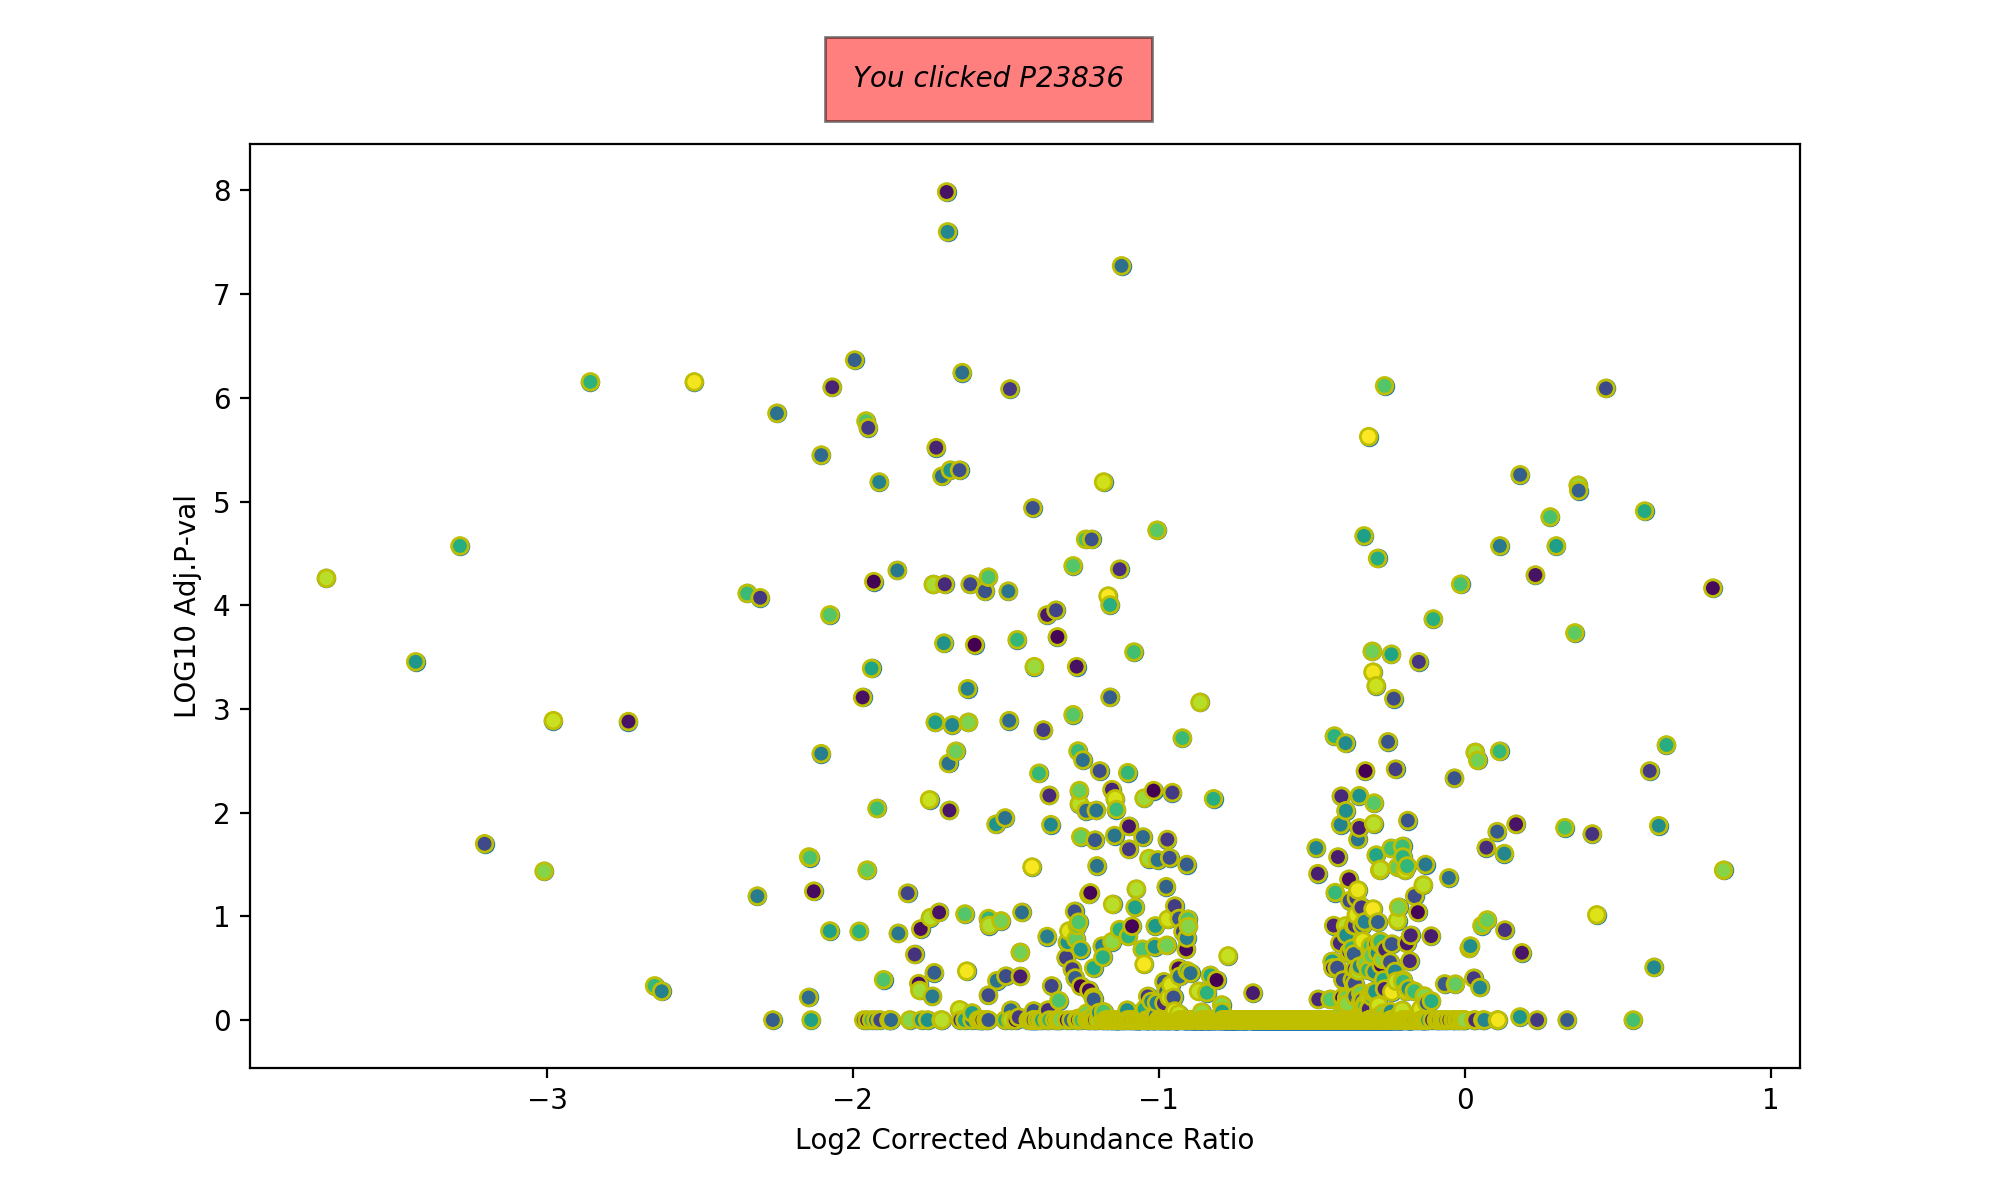

9

--> PathwayY
--> Pathway Z


In [8]:
#https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
# https://stackoverflow.com/questions/7908636/possible-to-make-labels-appear-when-hovering-over-a-point-in-matplotlib
%matplotlib notebook
#plt.close('all')
#matplotlib.use('nbagg')

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

# Define the content of the Dropdown list
selWidget = widgets.Dropdown(description='Clicks select:', 
                             value= 'PathwayX', options=('PathwayX', 'PathwayY', 'Pathway Z') 
                            )

rsWidget = widgets.FloatSlider(
    value=7.5,
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
rsWidget = widgets.FloatRangeSlider(
    value=[5, 7.5],
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

# Define the behaviour on list change     
def on_value_change(change):
    print("-->", change["new"])
    scat.set_array( np.random.random(len(x)) )

    txtBox.set_text(change["new"])
    fig.canvas.draw_idle()

def on_event(event):
    ind = event.ind[0]
    artist = event.artist
    #d = otherdata[scatters.index(artist)]
    
    
    scat.set_array( np.random.random(len(x)) )

    txtBox.set_text("You clicked {}".format(labels[ind]))

    fig.canvas.draw()
    fig.canvas.draw_idle()

def _onpick(event):
    ind = event.ind[0]
    artist = event.artist
    d = otherdata[scatters.index(artist)]
    scat.set_array( np.random.random(len(x)) )

    txtBox.set_text("You clicked {}".format(d[ind]))
    fig.canvas.draw_idle()
        #on_value_change({'new': 'toto'})
        
        
# Bind the change function to the list widget, display the widget    
selWidget.observe(on_value_change, names='value')
display(selWidget, rsWidget)

# Draw the figure in its initial state

x = [ float(i) for i in dfClean['Log2 Corrected Abundance Ratio'].tolist() ]
y = [ float(i) for i in dfClean['LOG10 Adj.P-val'].tolist() ]

scat,fig,ax = drawScatter(x, y)

txtBox = ax.text(-2, 9, 'boxed italics text in data coords', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})


fig.canvas.mpl_connect('pick_event', on_event)
fig.canvas.mpl_connect('key_press_event', on_event)

#plt.show()

<IPython.core.display.Javascript object>


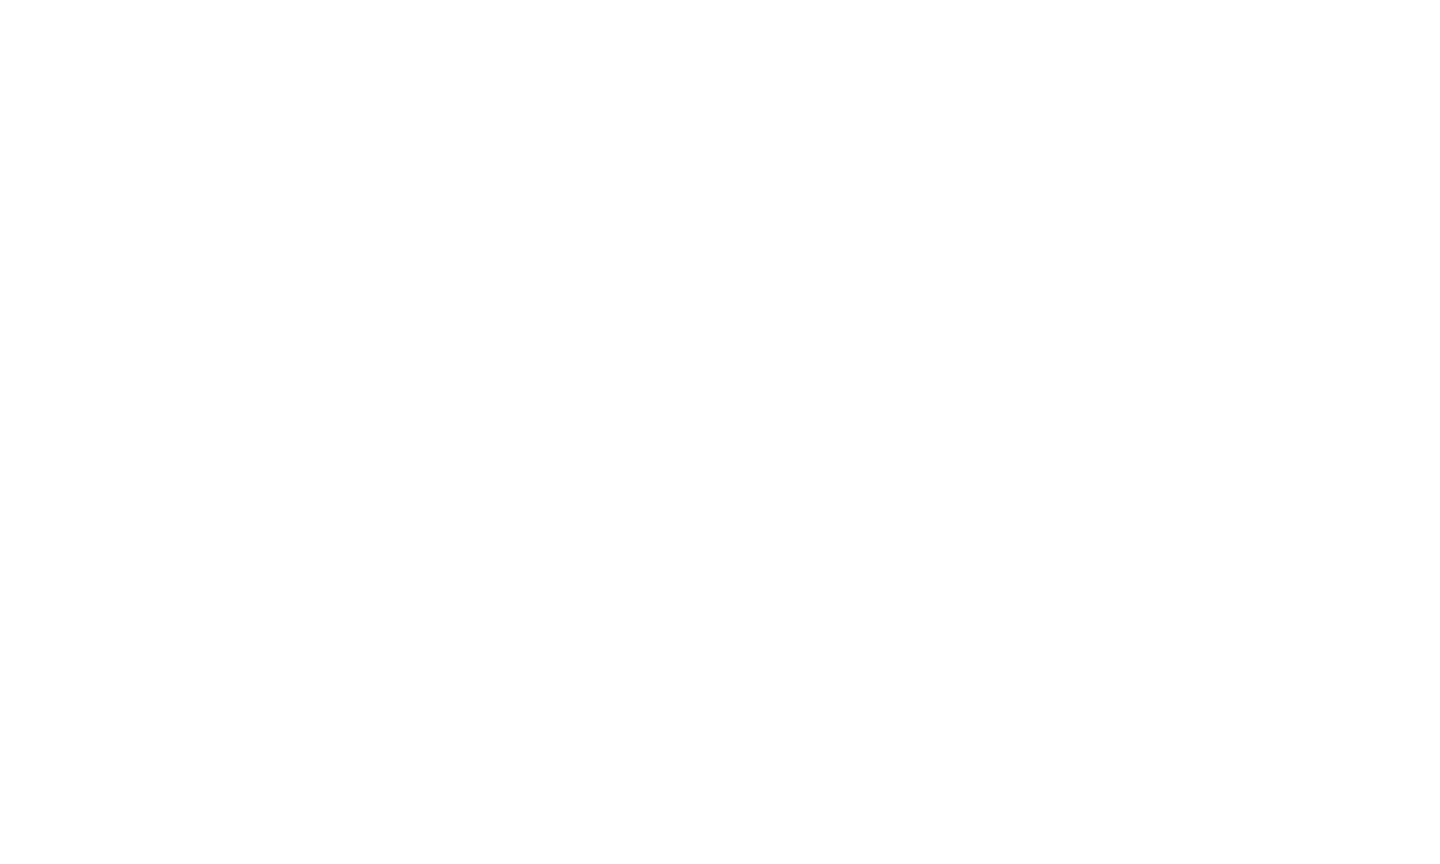

<IPython.core.display.Javascript object>


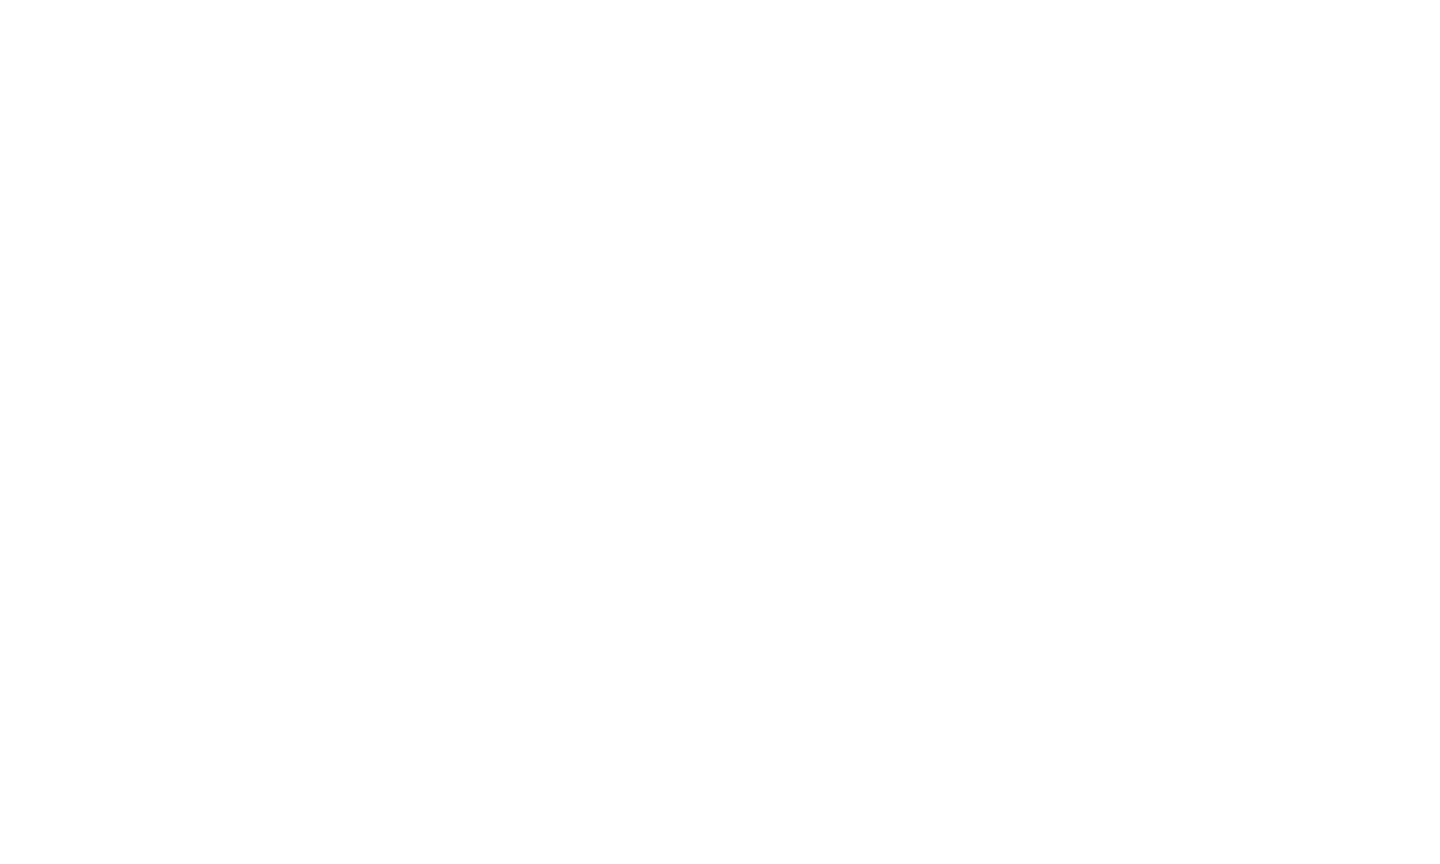

In [131]:
scat,fig,ax = drawScatter(x, y)

In [45]:
plt.get_backend()

'nbAgg'

<IPython.core.display.Javascript object>


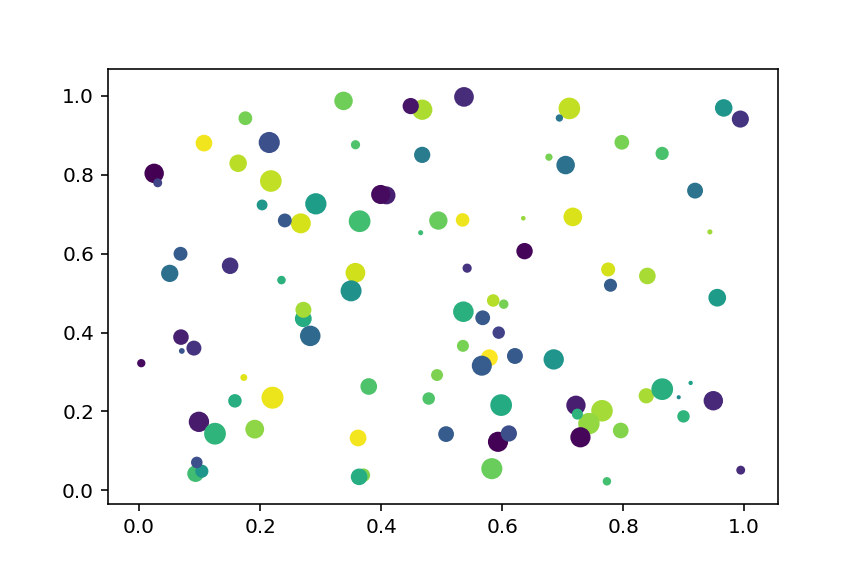

In [15]:
#%matplotlib widget
import matplotlib.pyplot

from matplotlib.pyplot import figure, show
import numpy as npy
from numpy.random import rand


if 1: # picking on a scatter plot (matplotlib.collections.RegularPolyCollection)

    x, y, c, s = rand(4, 100)
    def onpick3(event):
        ind = event.ind
        print ('onpick3 scatter:', ind, npy.take(x, ind), npy.take(y, ind))

    fig = figure()
    ax1 = fig.add_subplot(111)
    col = ax1.scatter(x, y, 100*s, c, picker=True)
    #fig.savefig('pscoll.eps')
    fig.canvas.mpl_connect('pick_event', onpick3)

show()